In [1]:
import sumie
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

%load_ext autoreload

%autoreload 2

In [2]:
model = torchvision.models.vgg16(pretrained=True).eval()
sumie.utils.remove_inplace(model)
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU()
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), pad

100%|██████████| 1000/1000 [05:57<00:00,  2.77it/s]


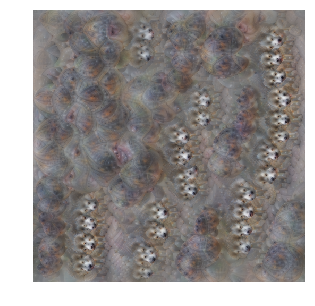

In [6]:
def scale_image(i, image, model, objective, opt):
    if i % 2 == 0:
        scaled = torch.nn.functional.interpolate(image.base_image.pixels.data, scale_factor=1.005, mode='bilinear', align_corners=False)
        original_size = image.base_image.pixels.data.size()
        image.base_image.pixels.data = scaled[:original_size[0],:original_size[1],:original_size[2],:original_size[3]]
    
def change_objective(i, image, model, objective, opt):
    if i % 100 == 0:
        opt.objective = sumie.objectives.ConvChannel(model[26], np.random.randint(512), func=torch.std)

im = sumie.Image(512, param='fft', transforms=
              [sumie.transforms.PositionJitter(8),
              sumie.transforms.Normalise(),]
            )

device = 'cuda'
im.to(device)
model.to(device)
opt = sumie.Optimiser()
opt.add_callback(change_objective)
channel = sumie.objectives.ConvChannel(model.features[26], 0)

opt.run(im, model.features, channel, iterations=1000, progress=True, lr=0.025, output='tmp')
sumie.vis.show(im.get_image())

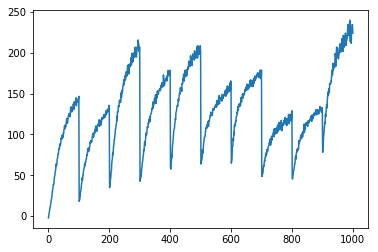

In [4]:
plt.plot([x.item() for x in opt.history])

NameError: name 'animation' is not defined

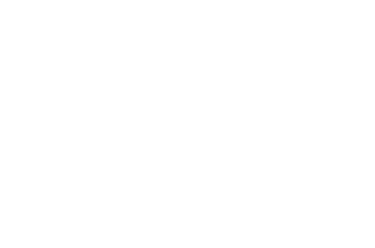

In [5]:
def to_frame(i):
  return animation[i,:,:,:].squeeze(0).permute((1, 2, 0)).numpy()

fig = plt.figure()
ax = plt.axes(xlim=(0, 224), ylim=(0, 224))
plt.axis('off')
ax.grid(False)
im=plt.imshow(to_frame(0))

# initialization function: plot the background of each frame
def init():
    im.set_data(to_frame(0))
    return [im]

# animation function.  This is called sequentially
def animate(i):
  if i<100:
    im.set_array(to_frame(i))
  else:
    im.set_array(to_frame(199-i))
  return [im]
  
anim = matplotlib.animation.FuncAnimation(fig, animate, init_func=init,
                               frames=200, interval=20, 
                               blit=True, repeat=True)
#HTML(anim.to_jshtml())

In [ ]:
HTML(anim.to_html5_video())